In [1]:
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation
import matplotlib

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances


import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np

from sgptools.utils.metrics import *
from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.utils.tsp import run_tsp

from sgptools.models.cma_es import *
from sgptools.models.continuous_sgp import *
from sgptools.models.core.transformations import *

np.random.seed(0)
tf.random.set_seed(0)

2024-03-13 17:16:30.992557: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 17:16:31.026358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 17:16:31.027139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 17:16:31.635597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_corners(X, size):
    corners = np.zeros((X.shape[0]//(size**2), 5, 3))
    X = X.reshape(-1, size**2, 2)
    corners[:, 0, :2] = X.min(axis=1)
    corners[:, 1, :2] = np.array([X[:, :, 0].min(axis=1), X[:, :, 1].max(axis=1)]).T
    corners[:, 2, :2] = X.max(axis=1)
    corners[:, 3, :2] = np.array([X[:, :, 0].max(axis=1), X[:, :, 1].min(axis=1)]).T
    # center
    corners[:, 4, :2] = X.mean(axis=1)
    return corners

def align_idx(a, b):
    dists = pairwise_distances(a, Y=b, metric='euclidean')
    _, ind = linear_sum_assignment(dists)
    return ind

'''
Get GP predictions with the solution placements as support points
'''
def get_reconstruction(X_test, y_test, Xu, data_variance, rbf):
    # Get test data indices corresponding to the solution placements
    dists = pairwise_distances(X_test, Y=Xu, metric='euclidean')
    row_ind, _ = linear_sum_assignment(dists)
    Xu_X = X_test[row_ind].copy()
    Xu_y = y_test[row_ind].copy()

    # Get GP predictions with the solution placements as support points
    gpr = gpflow.models.GPR((Xu_X, Xu_y),
                            noise_variance=data_variance,
                            kernel=rbf)
    y_pred, y_var = gpr.predict_f(X_test)
    y_pred = y_pred.numpy().reshape(-1, 1)

    rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    return y_pred, y_var, Xu_X, rmse

(900, 2) (900, 1)
(22500, 2) (22500, 1)


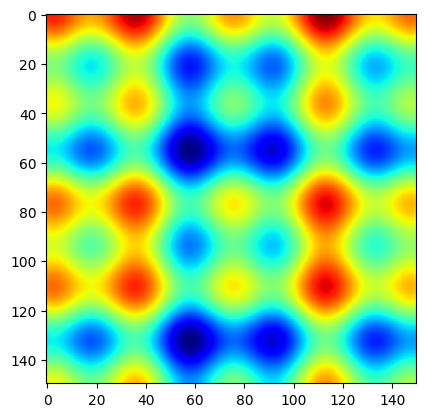

In [3]:
data_dims = (150, 150)
x = np.linspace(0, 50, data_dims[0])
y = np.linspace(0, 50, data_dims[1])
X, Y = np.meshgrid(x, y)

Z1 = np.sin(X/5) + np.cos(Y/5)
Z2 = np.cos(X/2) + np.cos(Y/2)

Z = Z1 + Z2

# subsample
X_ = X[::5, ::5]
Y_ = Y[::5, ::5]
Z_ = Z[::5, ::5]

X_train = np.stack([X_.ravel(), Y_.ravel()], axis=1)
y_train = Z_.ravel()[:, None]
train_dim = np.sqrt(X_train.shape[0]).astype(int)
print(X_train.shape, y_train.shape)

X_test = np.stack([X.ravel(), Y.ravel()], axis=1)
y_test = Z.ravel()[:, None]
test_dim = np.sqrt(X_test.shape[0]).astype(int)
print(X_test.shape, y_test.shape)

plt.figure()
plt.imshow(Z, cmap='jet')
plt.gca().set_aspect('equal')
plt.show()

2024-03-13 17:16:35.650248: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


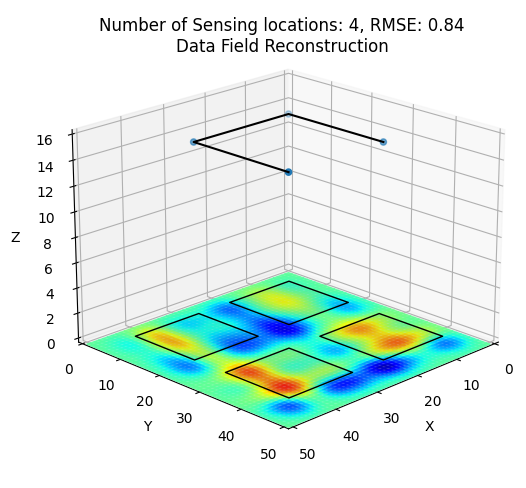

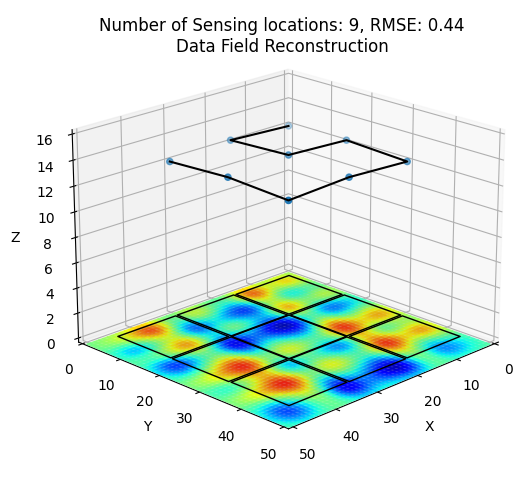

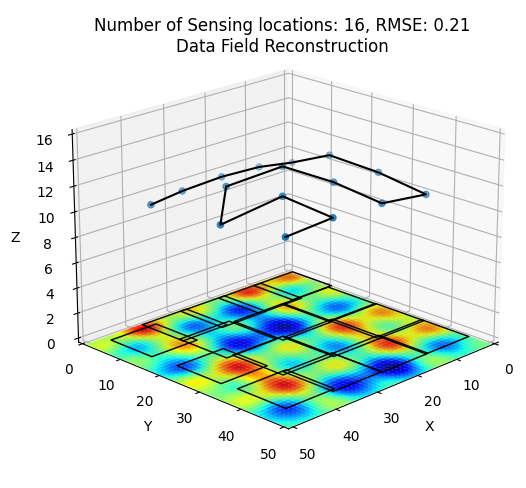

In [4]:
# Train the GP and get the model parameters
kernel = gpflow.kernels.RBF(lengthscales=3, variance=0.027)
noise_variance = 0.001
norm = colors.Normalize(y_train.min(), y_train.max())
num_samples = 4

for num_placements in [4, 9, 16]:
    Xu_init = get_inducing_pts(X_train, num_placements, random=False)
    Xu_init *= 0.2
    Xu_init += np.array([10, 10])
    Xu_init = np.concatenate((Xu_init, np.ones((Xu_init.shape[0], 1))*10), axis=1)

    transformer = SquareHeightTransformer(num_samples)
    sgpr, trace = continuous_sgp(num_placements,
                                X_train, 
                                noise_variance,
                                kernel,
                                transformer=transformer,
                                Xu_init=Xu_init,
                                max_steps=5000,
                                trace_fn='traceXu')

    sgp_sol_sp = trace[-1]
    sgp_sol_sp = run_tsp(sgp_sol_sp)[0][0]

    ########## Get reconstructed solution ##########

    sgp_sol, sgp_var, sgp_sol_X, rmse = get_reconstruction(X_test, y_test, 
                                                           transformer.expand(sgp_sol_sp).numpy(),
                                                           noise_variance, 
                                                           kernel)
    
    ########## Get the corners of FoV ##########

    vertices = get_corners(sgpr.transformer.expand(sgp_sol_sp).numpy(), num_samples)
    idx = align_idx(vertices[:, 4, :2], sgp_sol_sp[:, :2])
    vertices[:, 4] = sgp_sol_sp[idx]

    ########## 3D plot ##########

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

    # Plot the reconstructed solution
    cset = ax.plot_surface(X_test[:, 0].reshape(test_dim, test_dim),
                           X_test[:, 1].reshape(test_dim, test_dim),
                           np.atleast_2d(-0.5),
                           facecolors=plt.cm.jet(norm(sgp_sol.reshape(test_dim, test_dim))),
                           shade=False,
                           alpha=0.8,
                           zorder=0)

    #ax.scatter(sp[:, 0], sp[:, 1], 0, c='k', s=0.1)
    ax.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], sgp_sol_sp[:, 2])
    ax.plot(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], sgp_sol_sp[:, 2], 'k-')
    vertices[:, :, 2] = 0

    for i in range(vertices.shape[0]):
        verts = []
        verts.append([vertices[i, 0], vertices[i, 1], 
                    vertices[i, 2], vertices[i, 3]])
        ax.add_collection3d(Poly3DCollection(verts, linewidths=1.0, 
                                             edgecolors='k', alpha=0.1))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_zlim(0, 16)

    ax.view_init(elev=20., azim=45)

    ax.set_title(f'Number of Sensing locations: {num_placements}, RMSE: {rmse:.2f}\nData Field Reconstruction', y=0.97)

    plt.tight_layout()
    plt.savefig(f'./sp_height_{num_placements}.pdf', bbox_inches='tight')

    plt.show()